In [1]:
''' Predict the duration of diabetes with a Random Forest Regressor, 
        then compute the r2 score.
            
    We will predict with and compare results from the following methods,
    
        Random Forest
    
    Data source: https://figshare.com/articles/dataset/Circulating_osteocalcin_as_a_bone-derived_hormone_is_inversely_correlated_with_body_fat_in_patients_with_type_1_diabetes/8079389?file=15057092

'''

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

def moving_average(x, w=3):
    return np.convolve(x, np.ones(w)/w, mode='valid')

def remove_field_name(a, name):
    '''Delete record array column'''
    names = list(a.dtype.names)
    if name in names:
        names.remove(name)
    b = a[names]
    return b

FILE_PATH = '../../datasets/learn_statistics/pone.0216416.s003.xlsx'

In [2]:
df = pd.read_excel(FILE_PATH, header=0)
print(df.columns.values)
df.describe()

['no' 'gender (male=1, female=0)' 'age' 'duration of diabetes' 'BMI'
 'insulin regimen (MDI=1, CSII=0)' 'TDD' 'TDD/kg' 'basal' 'basal/kg'
 'bolus' 'bolus/kg' 'HbA1c' 'eGFR' '%body fat' 'adiponectin'
 'free-testosterone' 'SMI' 'grip strength' 'knee extension strength'
 'gait speed' 'ucOC' 'OC']


no  gender (male=1, female=0)        age  duration of diabetes  \
count  73.000000                  73.000000  73.000000             73.000000   
mean   37.000000                   0.301370  34.726027             25.684932   
std    21.217131                   0.462028   6.165000              7.334994   
min     1.000000                   0.000000  21.000000             10.000000   
25%    19.000000                   0.000000  31.000000             20.000000   
50%    37.000000                   0.000000  35.000000             26.000000   
75%    55.000000                   1.000000  39.000000             31.000000   
max    73.000000                   1.000000  48.000000             41.000000   

             BMI  insulin regimen (MDI=1, CSII=0)         TDD     TDD/kg  \
count  73.000000                        73.000000   73.000000  73.000000   
mean   23.765018                         0.465753   43.866096   0.680119   
std     3.475343                         0.502278   19.853618   0.205106   
min    17.584709                         0.000000   15.700000   0.313373   
25%    21.507548                         0.000000   31.400000   0.524079   
50%    22.895473                         0.000000   40.000000   0.647059   
75%    24.981453                         1.000000   50.000000   0.773869   
max    35.540961                         1.000000  154.000000   1.468065   

           basal   basal/kg  ...        eGFR  %body fat  adiponectin  \
count  73.000000  73.000000  ...   73.000000  71.000000    73.000000   
mean   16.232409   0.254672  ...   92.861458   0.268179    14.301370   
std     8.085368   0.102353  ...   14.060275   0.072282     6.214935   
min     0.000000   0.000000  ...   50.706049   0.138728     3.500000   
25%    11.520001   0.196149  ...   85.409093   0.220286    10.000000   
50%    14.838999   0.247994  ...   92.742008   0.258410    12.900000   
75%    18.722001   0.291387  ...  101.713259   0.303822    17.300000   
max    60.059998   0.638641  ...  127.014597   0.466588    32.300000   

       free-testosterone        SMI  grip strength  knee extension strength  \
count          73.000000  71.000000      72.000000                73.000000   
mean            4.239726   6.930986      32.080417                20.591781   
std             5.036195   0.883757       8.769605                 5.851229   
min             0.400000   5.500000      16.799999                 8.700000   
25%             0.900000   6.300000      25.550000                17.500000   
50%             1.300000   6.700000      30.200000                20.000000   
75%             8.300000   7.450000      37.450000                25.000000   
max            18.100000   9.200000      54.500000                39.099998   

       gait speed       ucOC         OC  
count   72.000000  73.000000  73.000000  
mean     1.341528   4.171233  16.450685  
std      0.222620   3.258306   7.889940  
min      0.810000   0.530000   6.400000  
25%      1.210000   2.400000  11.700000  
50%      1.310000   3.250000  14.800000  
75%      1.497500   4.660000  18.400000  
max      2.000000  19.100000  49.600000  

[8 rows x 23 columns]

In [3]:
# Only a few entries are empty, let's fill them with the mean
df = df.fillna(df.mean())

# We will work with record arrays from here on
rec = df.to_records(index=0)
del df

# the 'no' column is redundant
rec = remove_field_name(rec, 'no')

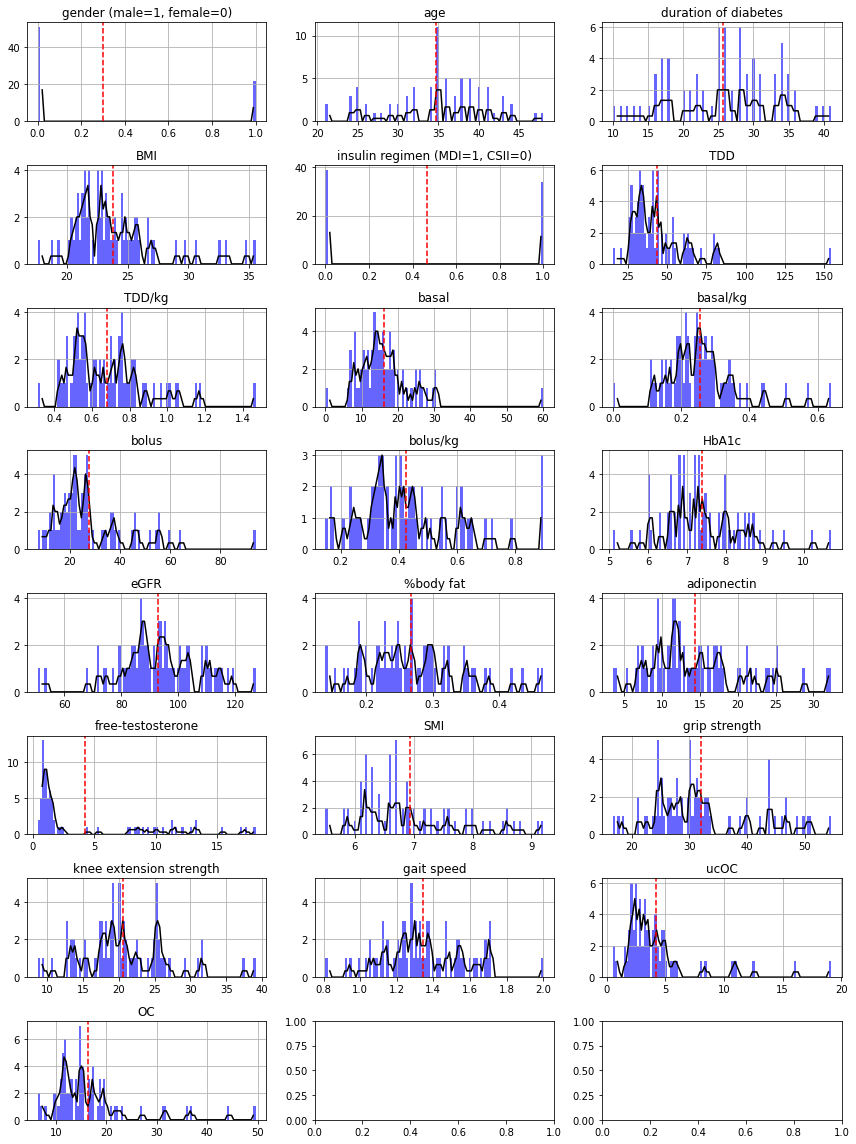

In [4]:
# Let's plot everything as a histogram
#

n_names = len(rec.dtype.names)
n_rows = int(np.ceil(n_names/3))

w = 3  # for the moving average

# 3 axes per row with figsize(s) = (2, 4)
fig, axes = plt.subplots(n_rows, 3, figsize=(3*4, 2*n_rows))

for i, ax in enumerate(axes.flatten()):
    
    if i < n_names:
        name = rec.dtype.names[i]

        a, b, _ = ax.hist(rec[name], bins=100, alpha=.6, color='b')
        ax.plot(b[w-1:-1], moving_average(a, w), 'k')
        ax.axvline(np.mean(rec[name]), c='r', ls='--')

        ax.set_title(name)
        ax.grid()

plt.tight_layout()
plt.show()
fig.savefig('histograms.png')

In [5]:
# 'duration of diabetes' is our target
y = rec['duration of diabetes']
rec = remove_field_name(rec, 'duration of diabetes')
#rec = remove_field_name(rec, 'age')

# Move recarray to an array, cast all int columns to float
X = np.empty(shape=(len(rec), len(rec.dtype.names)), dtype=float)
for j, name in enumerate(rec.dtype.names):
    X[:, j] = rec[name]

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size = 0.3, 
    random_state = 3) 

print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(51, 21)
(22, 21)
(51,)
(22,)


In [7]:
Model = RandomForestRegressor()
Model.fit(X=X_train, y=y_train)

y_pred = Model.predict(X=X_valid)
fscores = Model.feature_importances_

In [8]:
r2_score = Model.score(X_valid, y_valid)
r2_score

0.6196659811006114

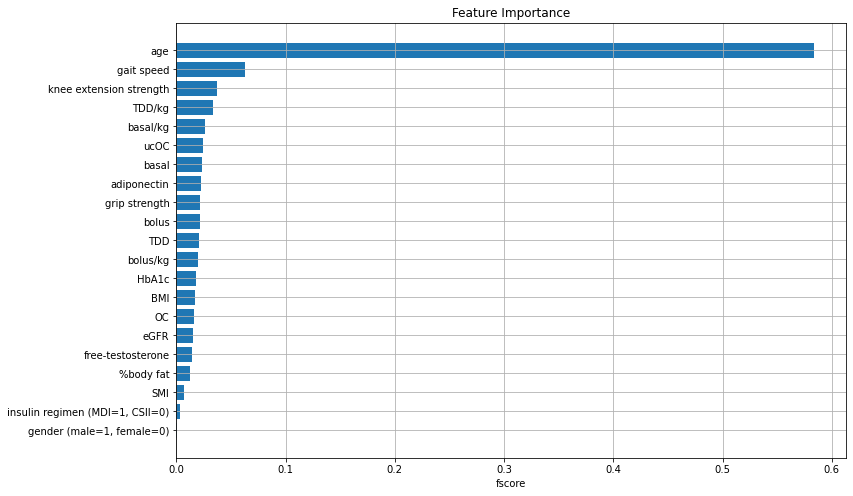

In [9]:
fig, ax = plt.subplots(1, figsize=(12, 8))

names = np.array(rec.dtype.names)
ypos = np.arange(len(names))
idx = np.argsort(fscores)

ax.barh(ypos, fscores[idx])

ax.set_yticks(ypos)
ax.set_yticklabels(names[idx])
ax.set_xlabel('fscore')
ax.set_title('Feature Importance')
ax.grid()
plt.show()

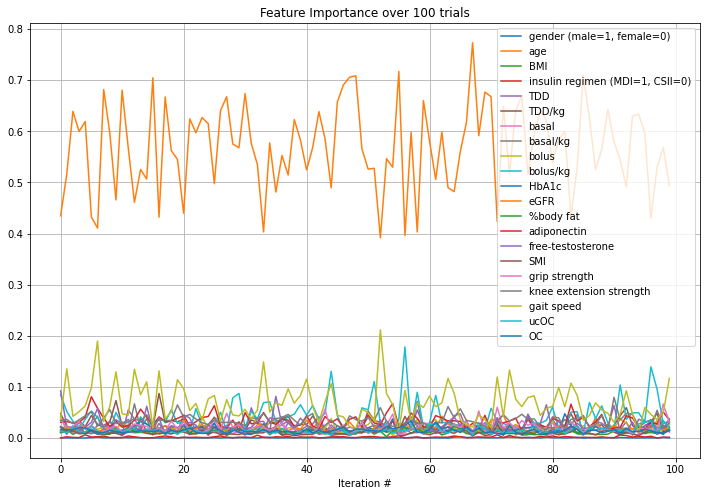

In [10]:
fscores_all = []

for i in range(100):
    
    X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size = 0.3, 
    random_state = i) 
    
    Model = RandomForestRegressor()
    Model.fit(X=X_train, y=y_train)

    y_pred = Model.predict(X=X_valid)
    fscores = Model.feature_importances_
    
    fscores_all.append(fscores)
    
arr = np.array(fscores_all)
arr.shape

fig, ax = plt.subplots(1, figsize=(12, 8))

for i, name in enumerate(rec.dtype.names):
    ax.plot(arr[:, i], label=name)

plt.legend()
ax.set_xlabel('Iteration #')
ax.set_title('Feature Importance over 100 trials')
ax.grid()
plt.show()